## データの取り込み

In [1]:
#基本ライブラリのインポート
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(font="IPAexGothic",style="white")
pd.set_option('display.max_columns', 100)

In [2]:
#ファイルの読み込み
import codecs
with codecs.open('review_score_train.csv', 'r', 'utf-8', 'ignore') as f:
    df = pd.read_csv(f)
df.head()

,index,review_text,review_score
0,80351,Sunday is relaxing day. But I want to explore ...,2
1,24757,My wife and I visited this restaurant on a qui...,1
2,114219,Came to Shang Palace for dinner and enjoyed th...,5
3,134782,The snacks are very good quality and the take ...,4
4,23792,We didn't know what to expect but were thoroug...,5


In [3]:
#テストデータ読み込み
df_test=pd.read_csv("review_score_test.csv")
df_test.head()

,index,review_text
0,50923,Food is good but too much non veg dish creates...
1,48414,We love the buffet here. it is very famous fo...
2,17951,Great place for a chill evening on the weekday...
3,36227,A legendary restaurant of Delhi (and India) th...
4,30281,I had to walk for 2 hours and got lost trying ...


## EDA

In [4]:
#データ数と欠損の確認
display(df.describe().T)
display(df.isnull().sum())
display(df_test.isnull().sum())

#trainデータの欠損は削除する必要あり、データ数は十分

,count,mean,std,min,25%,50%,75%,max
index,118064.0,73831.045145,42598.961069,1.0,36960.5,73812.0,110724.25,147580.0
review_score,118064.0,4.229079,0.970274,1.0,4.0,4.0,5.00,5.0


index           0
review_text     2
review_score    0
dtype: int64

index          0
review_text    0
dtype: int64

In [5]:
#欠損行の削除
df = df.dropna()
display(df.isnull().sum())

index           0
review_text     0
review_score    0
dtype: int64

review_score
5    57872
4    40127
3    12859
2     3645
1     3559
Name: count, dtype: int64


<Axes: xlabel='review_score', ylabel='count'>

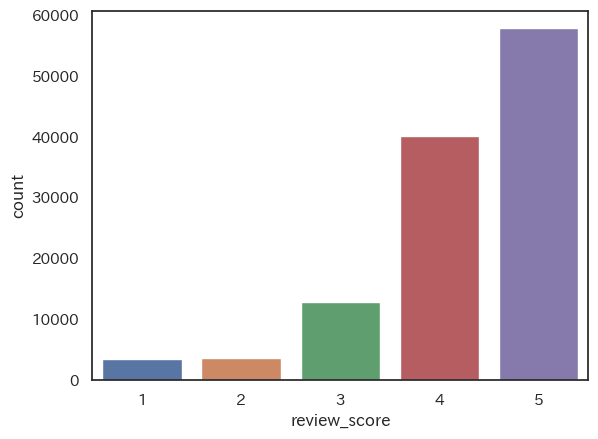

In [6]:
#review_score
print(df["review_score"].value_counts())
sns.countplot(x="review_score", data=df)

#5と4が多い

In [7]:
#星5レビューの内容
df.query('review_score == 5')["review_text"].head(20)

2     Came to Shang Palace for dinner and enjoyed th...
4     We didn't know what to expect but were thoroug...
7     This the the best place to have food at a pock...
8     The whole experience is out of our expectation...
9     Such a cute place with great ambience and amaz...
11    The food there was really authentic indian , g...
16    I came at The Pavellion for the lunch with my ...
23    What a great place. It's comfortable, the staf...
24    I have been to Saravana Bhavan several times, ...
25    Fantastic experience! Nothing to fault! Everyt...
26    A place one might go to tantalize their Tongue...
28    If you want a change from the usual fare at ot...
29    Its a expensive fine dining place and is a per...
30    I was so grateful for the welcome and the serv...
31    Great place for a good business meal. Non intr...
33    Place was very trendy. We ordered prawns tando...
34    As an Australian visiting India, I was impress...
36    Wonderful service 5 star given by chef Dho

In [8]:
#星1レビューの内容
df.query('review_score == 1')["review_text"].head(20)

1      My wife and I visited this restaurant on a qui...
5      Was pretty excited initially to find a place b...
66     Had a friend's bday party. Seems the cook was ...
67     In a strictly simplistic point of view piano m...
83     I am listing all things which went wrong durin...
88     One of the worst place I ever visited in my li...
97     I went to this nonsense & most crappy restaura...
101    ridiculous staff and they cannot deliver the o...
153    There was a black hair stuck to the bread they...
219    The a/c didn't work for the first hour. The mu...
245    The worst afternoon tea I ever had And I reall...
291    The Worst service experience I ever had with r...
317    Don't bother coming here! This place is so ove...
341    horrible service the staff just crawl, nothing...
445    Food order was forgotten and reordering had to...
466    Friends i really mean it and my review make lo...
480    It was a bad experience over all, even Mr SANJ...
490    Had a very bad experienc

review_score,1,2,3,4,5
count,3559.000000,3645.000000,12859.000000,40127.000000,57872.000000
mean,573.415566,546.690535,442.863131,410.296957,373.665503
std,519.638345,484.238357,438.049249,482.532301,443.531236
min,6.000000,25.000000,6.000000,6.000000,6.000000
25%,232.000000,233.000000,188.000000,165.000000,154.000000
50%,414.000000,398.000000,307.000000,266.000000,243.000000
75%,732.000000,678.000000,538.000000,464.000000,416.000000
max,8180.000000,6486.000000,6123.000000,8192.000000,8192.000000


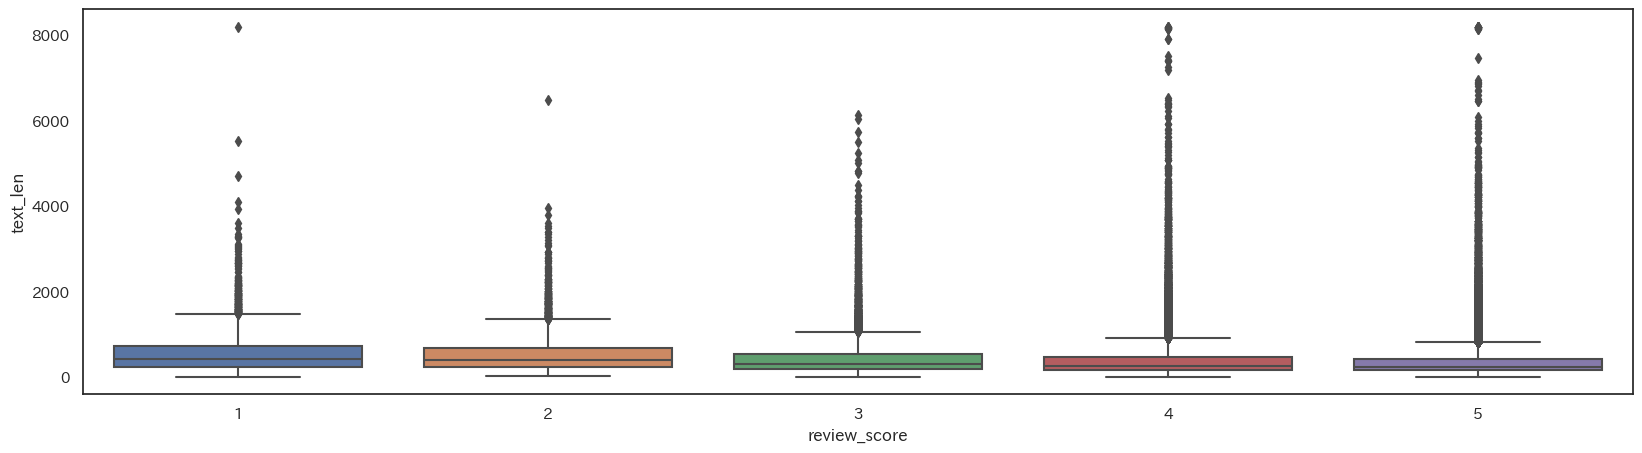

In [9]:
#文章の文字数をカウント
df['text_len'] = df["review_text"].apply(len)
df_test['text_len'] = df_test["review_text"].apply(len)
fig = plt.subplots(figsize=(20,5))
sns.boxplot(x="review_score", y="text_len", data=df)
df.groupby("review_score").describe()["text_len"].T

#レビューが高いほど文字数が少ない傾向がある

In [10]:
#文章のクリーニングに必要なモジュールのインポート
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
#STOPWORDS→解析に必要ない単語のリスト

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/knishiura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#文字を全て小文字に→英数字以外を削除→複数の空白を削除→STOPWORDSでない単語のみ抜き出して文章を再構築(clean_text)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^0-9a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = " ".join(word for word in text.split() if word not in STOPWORDS)
    return text

df['clean_text'] = df["review_text"].apply(clean_text)
df_test["clean_text"] = df_test["review_text"].apply(clean_text)
df.head()

,index,review_text,review_score,text_len,clean_text
0,80351,Sunday is relaxing day. But I want to explore ...,2,653,sunday relaxing day want explore new cafe hauz...
1,24757,My wife and I visited this restaurant on a qui...,1,1024,wife visited restaurant quiet monday evening f...
2,114219,Came to Shang Palace for dinner and enjoyed th...,5,195,came shang palace dinner enjoyed flavorful dis...
3,134782,The snacks are very good quality and the take ...,4,100,snacks good quality take aways really nice enj...
4,23792,We didn't know what to expect but were thoroug...,5,182,know expect thoroughly amazed place decor atmo...


<Axes: >

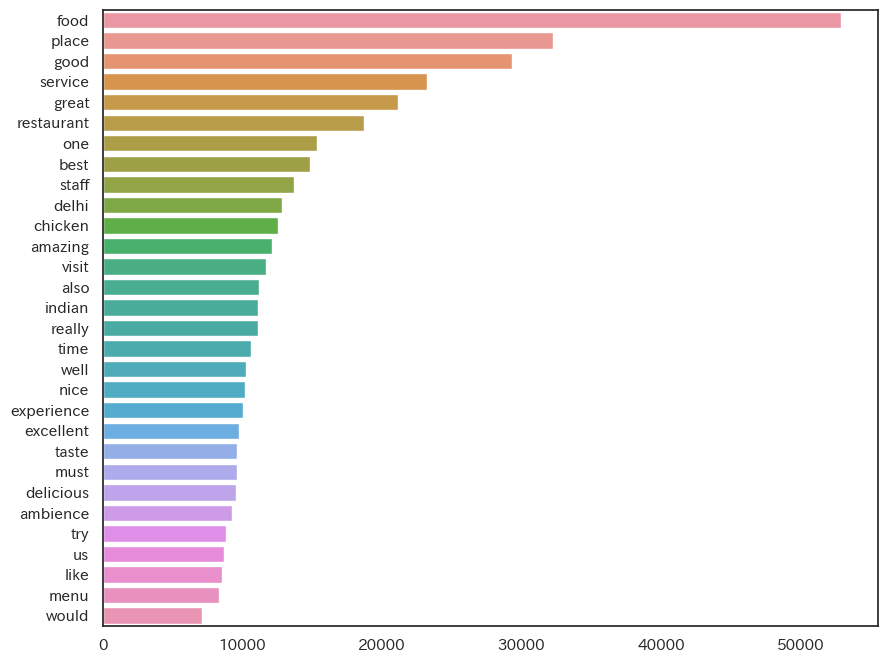

In [12]:
#星5レビューによく使われている単語を探索
from collections import Counter
words = df[df["review_score"] == 5].clean_text.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()
for msg in words:
    spam_words.update(msg)

x = [x[1] for x in spam_words.most_common(30)][:30]
y = [label[0] for label in spam_words.most_common(30)][:30]
plt.figure(figsize=(10, 8))
sns.barplot(x=x,y=y)

<Axes: >

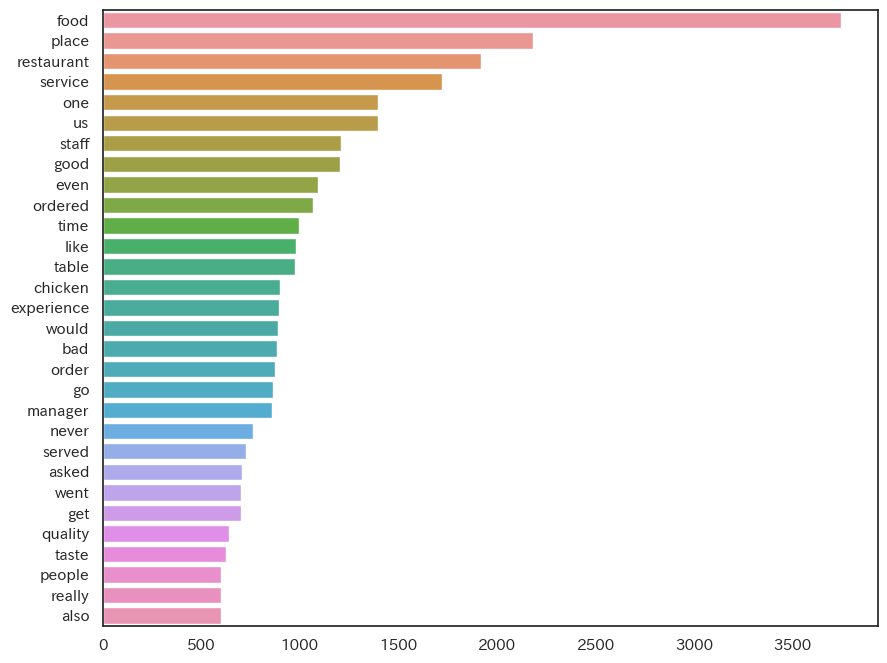

In [13]:
#星1レビューによく使われている単語を探索
from collections import Counter
words = df[df["review_score"] == 1].clean_text.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()
for msg in words:
    spam_words.update(msg)

x = [x[1] for x in spam_words.most_common(30)][:30]
y = [label[0] for label in spam_words.most_common(30)][:30]
plt.figure(figsize=(10, 8))
sns.barplot(x=x,y=y)

#even, ordered, timeの出現数が多い
#頼んでから料理が車での時間が長いことに不満があった人が多いのかも？

review_score,1,2,3,4,5
count,3559.000000,3645.000000,12859.000000,40127.000000,57872.000000
mean,0.631694,0.628081,0.643747,0.667544,0.676160
std,0.063754,0.061873,0.068058,0.069593,0.072247
min,0.204444,0.138235,0.167398,0.113821,0.125000
25%,0.592496,0.589147,0.599422,0.621622,0.628436
50%,0.628227,0.625000,0.640889,0.664623,0.672897
75%,0.667025,0.664634,0.683954,0.710660,0.720528
max,0.909091,1.000000,1.000000,1.000000,1.000000


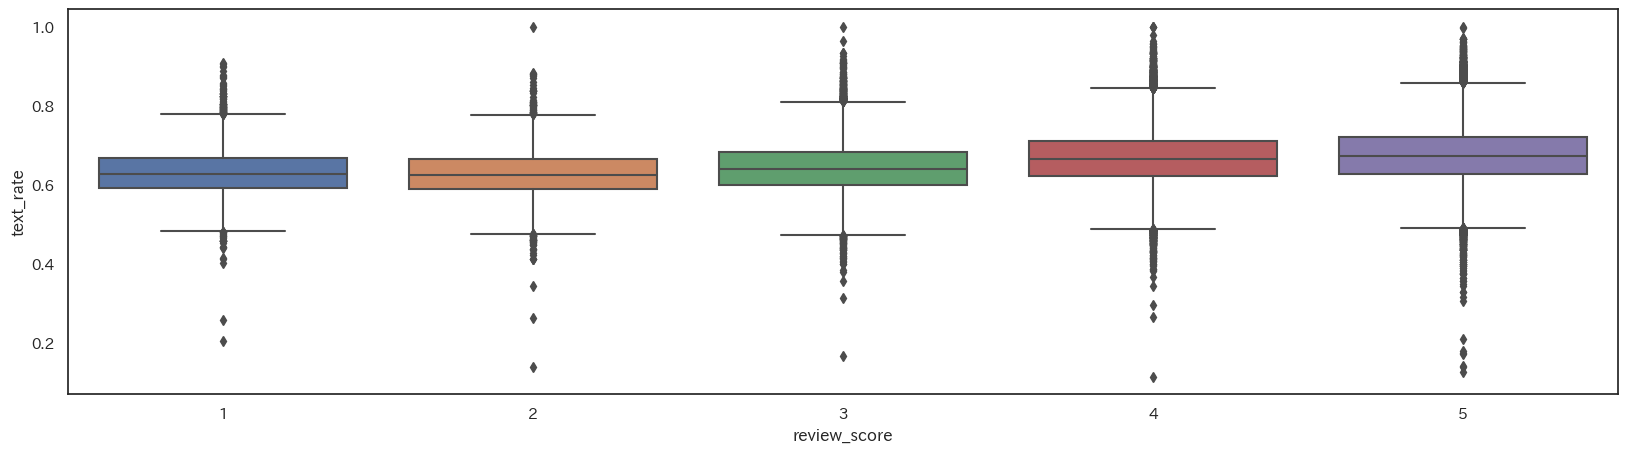

In [14]:
#クリーニング前後の文字数の比率を算出(文章に対する記号以外の文字の割合)
df['text_rate'] = df["clean_text"].apply(len) / df["text_len"]
df_test['text_rate'] = df_test["clean_text"].apply(len) / df["text_len"]
fig = plt.subplots(figsize=(20,5))
sns.boxplot(x="review_score", y="text_rate", data=df)
df.groupby("review_score").describe()["text_rate"].T

#スコアが高いほどrateが上がる傾向がある

## 前処理(BoWの形に変換)

In [15]:
#クリーニングした文章を使ってBoWのデータフレームを作成
X = df["clean_text"]
y = df["review_score"]
testX = df_test["clean_text"]

#CountVectorizerで単語の出現数をカウントしたデータフレームを作成
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X_dtm = vect.fit_transform(X)
X_dtm_test = vect.transform(testX)

In [16]:
#合計出現回数が少ない(9回以下)単語を削除してカラム数を減らす
X_dtm_df = pd.DataFrame(X_dtm.toarray(), columns=vect.get_feature_names_out())
word_sum = X_dtm_df.sum()
choice_column = word_sum[word_sum >= 10].index
X_dtm_df = X_dtm_df[choice_column]

#BoW変換後のデータフレームに事前に作った特徴量を追加
X_dtm_df["text_len"] = df["text_len"]
X_dtm_df["text_rate"] = df["text_rate"]
X_dtm_df.head()

,00,000,00pm,01,011,02,03,04,05,06,...,zone,zones,zoo,zorawar,zu,zuber,zucchini,zune,text_len,text_rate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,653.0,0.699847
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1024.0,0.619141
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,195.0,0.697436
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100.0,0.580000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,182.0,0.576923


In [17]:
#テストデータも同様の作業を実行
X_dtm_test_df = pd.DataFrame(X_dtm_test.toarray(), columns=vect.get_feature_names_out())
X_dtm_test_df = X_dtm_test_df[choice_column]
X_dtm_test_df["text_len"] = df_test["text_len"]
X_dtm_test_df["text_rate"] = df_test["text_rate"]
X_dtm_test_df.head()

,00,000,00pm,01,011,02,03,04,05,06,...,zone,zones,zoo,zorawar,zu,zuber,zucchini,zune,text_len,text_rate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,109,0.143951
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,131,0.060547
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,303,1.015385
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,984,6.040000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,159,0.554945


## 予測、評価

In [18]:
#勾配ブースティング木モデルを構築(lightGBM)
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_dtm_df, y, test_size=0.2)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {"objective": "regression", "metrics": "rmse", "num_leaves": 23}
model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=2000, early_stopping_rounds=100, verbose_eval=50)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print("RMSE=", np.sqrt(mean_squared_error(y_test, y_pred)))

#重要単語の表示
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X_train.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False).head(30)
display(importance.T)

/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.763233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31086
[LightGBM] [Info] Number of data points in the train set: 94449, number of used features: 8840
[LightGBM] [Info] Start training from score 4.228642
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.693374	valid_1's rmse: 0.694775
[100]	training's rmse: 0.662692	valid_1's rmse: 0.671296
[150]	training's rmse: 0.648114	valid_1's rmse: 0.662787
[200]	training's rmse: 0.63759	valid_1's rmse: 0.658284
[250]	training's rmse: 0.628824	valid_1's rmse: 0.654771
[300]	training's rmse: 0.621814	valid_1's rmse: 0.652456
[350]	training's rmse: 0.615683	valid_1's rmse: 0.65103
[400]	training's rmse: 0.610166	valid_1's rmse: 0.649687
[450]	training's rmse: 0.605017	valid_1's rmse: 0.648657
[500]	training's

,bad,average,worst,poor,pathetic,ok,terrible,amazing,best,rude,...,asked,thanks,disappointing,said,ordered,better,good,awesome,waste,must
importance,24836.2722,22049.944061,17056.995754,12855.915183,12319.02189,7617.082512,6952.837107,6405.024483,5398.856186,5382.560838,...,3032.859707,2996.308486,2679.453847,2573.594379,2536.303531,2377.268339,2217.5428,2094.198302,1865.896081,1858.343123


In [19]:
#ベースラインモデル 全体の平均値を代入して予測
y_pred = [np.mean(y_train)] * len(y_test)
print("RMSE=", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))

#ベースラインを上回っていることを確認

RMSE= 0.9670987312900431


In [20]:
#submitデータ作成
y_pred = model.predict(X_dtm_test_df, num_iteration=model.best_iteration)
df_test["y"] = y_pred
df_submit = df_test[["index", "y"]]
df_submit.to_csv("review_score_submit.csv", index=False)
df_submit

#最終スコア0.65

,index,y
0,50923,3.795036
1,48414,4.586264
2,17951,4.649247
3,36227,4.344349
4,30281,4.270693
...,...,...
29512,111568,5.004577
29513,134484,3.749232
29514,130243,4.657631
29515,6809,4.644461


In [27]:
#lightGBMでfeature_importanceが高かった単語の出現頻度を星5レビューと星1レビューで比較する
df_merge = pd.merge(X_train[importance.index], y_train, left_index=True, right_index=True).query('review_score == 5 or review_score == 1')
df_merge.groupby("review_score").mean()

,bad,average,worst,poor,pathetic,ok,terrible,amazing,best,rude,excellent,text_rate,horrible,tasteless,great,text_len,delicious,nothing,bill,told,asked,thanks,disappointing,said,ordered,better,good,awesome,waste,must
review_score,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.117347,0.062794,0.069466,0.059655,0.053375,0.056907,0.043564,0.093014,0.125589,0.038462,0.069074,0.631981,0.039639,0.026688,0.215463,582.218995,0.071036,0.060047,0.076923,0.090659,0.102041,0.026295,0.026295,0.084380,0.207614,0.098509,0.508634,0.042779,0.020016,0.091837
5,0.019401,0.028228,0.004795,0.007942,0.003910,0.021638,0.002828,0.172441,0.221028,0.002705,0.143131,0.676263,0.002188,0.002188,0.333497,373.536895,0.145565,0.025056,0.017409,0.014384,0.021638,0.051587,0.005360,0.013942,0.116231,0.054292,0.577811,0.079987,0.002828,0.148737


良いレビューの特徴
*   amazing, best, excellent, great, deliciousなど味を褒める単語が使われている
*   文字数が少ない(詳しく内容を書かずに褒めている傾向がある)

悪いレビューの特徴
*   文字数が多い(具体的な不満がある人が多いのかも)
*   badなど悪い意味の単語の他には、rude, ok, bill, told, asked, ordered, saidなどの単語が使われている傾向がある
*   「rude, told, asked, ordered」といった接客態度に問題があって悪いレビューをもらっているケースがありそう
*   またbill(明細書)関連の不満を持っている人が多いのかもしれない
*   okという単語が多いことから、全部が悪いわけではなく一部に不満があるだけかもしれない

結論としては、味に関してはポジティブな意見は多そうだが接客や明細書関連にはネガティブな意見がありそう。  
上記の単語が使われている生のレビュー内容をみることで、もう少し具体的に掘り下げていくべきだと言える。  
特にbadなどの単語は"bad taste"なのか"bad staff"なのかで意味合いが違うため、詳しくみる価値がある。  
さらに時間やリソースに余裕があれば、1単語だけでなく2単語のBoWなどで解析していくことも可能。